# Graph-based learning

(This notebook is partly based on a workshop by Robert Peach and Mauricio Barahona: https://github.com/peach-lucien/networks_workshop/tree/main)

Here, we will go through an analysis of the *Caenorhabditis elegans* (C. elgans) connectome. C. elegans is the only organism for which the wiring diagram of its complete nervous system has been mapped with reasonable accuracy at the cellular level. Despite this structural information, which has been available for decades, it still proves difficult to understand the system, e.g, resolving the functional involvement of specific neurons in defined behavioural responses.

We will use data that Robert Peach has reconstructed from the following article with the inclusion of muscles https://www.nature.com/articles/nature24056. The connectome is composed of directed connections from one neuron to another neuron in accordance with their biological influence.
Each node falls into one of four categories:
1. Sensory neurons (S)
2. Inter neurons (I)
3. Motor neurons (M)
4. Muscles (U)

Therefore, we can model the nematode nervous system as a *directed network* whose nodes include neurons and muscles, and whose links represent the electrical and chemical synaptic connections between them, including neuromuscular junctions. The weights of the edges correspond to the number of synaptic connections between a pair of neurons.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.testing as npt
import pandas as pd

# We set a global configuration for matplotlib to obtain well-readable plots
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Pre-processing C. Elegans network data

We are provided with an adjacency matrix $A_\text{raw}$ of the C. Elgans network and metadata for the nodes (including neuron type, name and neuron class).

In [2]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/Methods for Data Science/2025/Lectures/9 Graphs/notebooks/'

# import adjacency matrix
A_raw = pd.read_csv(path+"celegans_adjacency_transposed.csv", index_col=0)
A_raw = A_raw.to_numpy()

# import node data
node_data = pd.read_csv(path+"celegans_nodedata.csv", index_col=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We can first plot $A_\text{raw}$ as a heatmap and observe that the matrix is very sparse with values ranging from 0 to over 30.

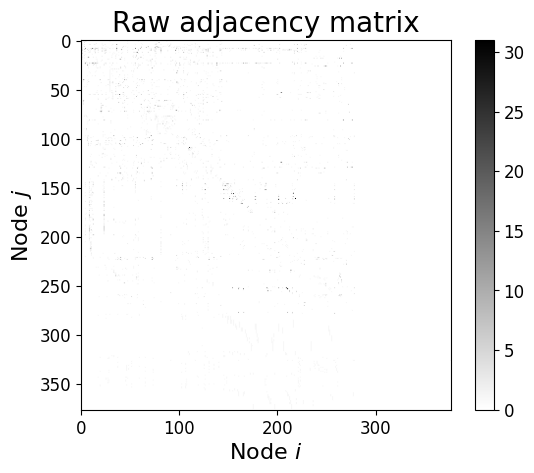

In [3]:
# plot raw adjacency matrix
fig, ax = plt.subplots(1)
im = ax.imshow(A_raw, cmap="binary")
plt.colorbar(im)
ax.set(title="Raw adjacency matrix", xlabel=r"Node $i$", ylabel=r"Node $j$")
plt.show()

Arguably, this visualisation of the adjacency matrix is not very illuminating. We will discuss better ways to visualise our data below. Let's first review the node metadata.

In [4]:
# look up node data
node_data.head()

,type,name,neuron_class
0,I,ADAR,ADA
1,I,ADAL,ADA
2,S,ADFL,ADF
3,S,ASHL,ASH
4,I,AVDR,AVD


We encode the node types with numerical values.

In [5]:
# transform node type into integers
type_to_value = {"S" : 0, "I" : 1, "M" : 2, "U" : 3}
value_to_type = {0 : "S", 1: "I", 2 : "M", 3 : "U"}
node_type = node_data["type"].map(type_to_value)
node_type = np.asarray(node_type)

Let us check some basic properties of the graph, in particular whether is undirected and unweighted.

In [6]:
# check properties of graph
print("Graph is undirected:", np.array_equal(A_raw, A_raw.T))
print("Graph is unweighted:", np.array_equal(np.unique(A_raw), np.arange(2)))

Graph is undirected: False
Graph is unweighted: False


To simply our analysis below, we go from the raw adjacency matrix $A_\text{raw}$ to the adjacency matrix $A$ of an undirected and unweighted graph, where $A_{ij}=A_{ji}=1$ if either $A_{\text{raw}, ij}>0$ or $A_{\text{raw}, ji}>0$ and $A_{ij}=A_{ji}=0$ otherwise.

In [7]:
## EDIT THIS CELL

# we go to undirected unweighted graph
A = np.zeros_like(A_raw)        # <-- SOLUTION
A[(A_raw + A_raw.T) > 0] = 1    # <-- SOLUTION

In [8]:
# double check if graph is now undirected and unweighted
print("Graph is undirected:", np.array_equal(A, A.T))
print("Graph is unweighted:", np.array_equal(np.unique(A), np.arange(2)))

Graph is undirected: True
Graph is unweighted: True


## Degree distribution of undirected C. Elegans network

Let us now compute the number of nodes and eges of our undirected unweighted graph given by $A$.

In [ ]:
## EDIT THIS CELL

# compute number of nodes
N = A_raw.shape[0]  # <-- SOLUTION
print("Number of nodes:", N)

# compute number of edges
M = int(A.sum()/2)  # <-- SOLUTION
print("Number of edges:", M)

Number of nodes: 377
Number of edges: 2850


As a first step of our analysis we look at the degree distribution $\boldsymbol{d}=A\boldsymbol{1}$.

In [ ]:
## EDIT THIS CELL

# compute degrees
d = A.sum(axis=0)   # <-- SOLUTION

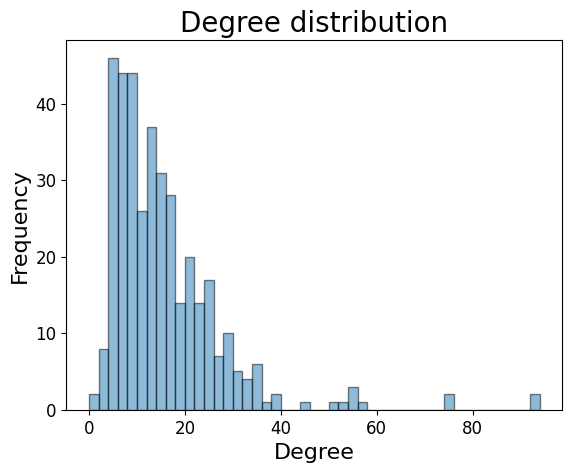

In [ ]:
# visualise degree distributions
fig, ax = plt.subplots(1)
bins = np.arange(0, d.max()+2,2)
ax.hist(d, bins=bins, alpha=0.5, edgecolor='black')
ax.set(xlabel="Degree", ylabel="Frequency", title="Degree distribution")
plt.show()

Let us look up the names and types two highest degree nodes.

In [ ]:
## EDIT THIS CELL

# check which node has highest degree
node1 = node_data.iloc[np.argsort(-d)[0]]   # <-- SOLUTION
print(f"Highest degree neuron is {node1['name']} of type {node1['type']}.") # <-- SOLUTION

# check which node has second highest degree
node2 = node_data.iloc[np.argsort(-d)[1]]   # <-- SOLUTION
print(f"Second highest degree neuron is {node2['name']} of type {node2['type']}.")  # <-- SOLUTION

Highest degree neuron is AVAR of type I.
Second highest degree neuron is AVAL of type I.


We notice that the two highest degree nodes are both of the same type inter neuron type (I). This suggests that it will be instructive to plot the degree distribution for the four different types of nodes.

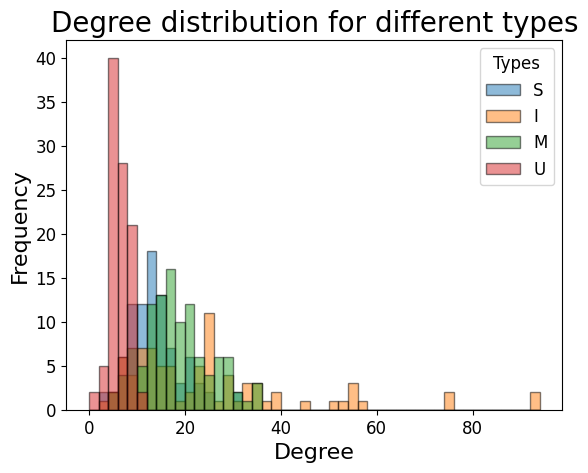

In [ ]:
# visualise degree distributions for the four different types
fig, ax = plt.subplots(1)
bins = np.arange(0,d.max()+2,2)
ax.hist(d[node_type==0], bins=bins,alpha=0.5, edgecolor='black', label=r"S")
ax.hist(d[node_type==1], bins=bins,alpha=0.5, edgecolor='black', label=r"I")
ax.hist(d[node_type==2], bins=bins,alpha=0.5, edgecolor='black', label=r"M")
ax.hist(d[node_type==3], bins=bins,alpha=0.5, edgecolor='black', label=r"U")
ax.set(xlabel="Degree",ylabel="Frequency",title="Degree distribution for different types")
ax.legend(title="Types")
plt.show()

From the degree distrubtions we can observe that the inter neurons (I) seem to have a higher degree, i.e., they are most connected, and the muscles (U) are the least connected in the nervous system.

We will define node colours consistent with this plot to use for later.

In [ ]:
# we define node colours consistent with the plot above
cmap = matplotlib.colormaps.get_cmap('tab10')
color_type = [cmap(i) for i in node_type]

## Spectral analysis of symmetric normalised Laplacian

We focus our analysis on the spectrum of the normalised graph Laplacian $L_\text{sym}$, which is given by:

$$L_\text{sym}=D^{-1/2} L D^{-1/2},$$

where $L=D-A$ is the combinatorial Laplacian and $D$ the diagonal degree matrix.

In [ ]:
## EDIT THIS CELL

# define diagonal degree matrix
D = np.diag(d)       # <-- SOLUTION

# compute combinatorial Laplacian
L = D - A            # <-- SOLUTION

# compute square root of inverse diagonal degree matrix
D_sqrt_inv = np.diag(1/np.sqrt(d))   # <-- SOLUTION

# compute symmetric normalised Laplacian
L_s = D_sqrt_inv @ L @ D_sqrt_inv    # <-- SOLUTION

We are now interested in the spectral decomposition of $L_\text{sym}$. We know that the first (smallest) eigenvalue is $\lambda_1=0$ with corresponding eigenvector $\boldsymbol{v}_1=D^{1/2}\boldsymbol{1}$ (can you prove this?).

In [ ]:
# the square-root of the degree vector is the zero eigenvector to eigenvalue 0
np.allclose(L_s @ np.sqrt(d),np.zeros(N))

True

To compute the full spectrum of $L_\text{sym}$, we use the fact that it is a real symmetric matrix and sort the eigenvalues (and corresponding eigenvectors) in ascending order.

In [ ]:
## EDIT THIS CELL

# compute eigen decomposition using the fact that L_s is symmetric
eigenvals, eigenvecs = np.linalg.eigh(L_s)       # <-- SOLUTION

# sort eigenvalues and corresponding eigenvector
eigenvecs = eigenvecs.T[np.argsort(eigenvals)]   # <-- SOLUTION
eigenvals = np.sort(eigenvals)                   # <-- SOLUTION

We can visualise the spectrum of $L_\text{sym}$.

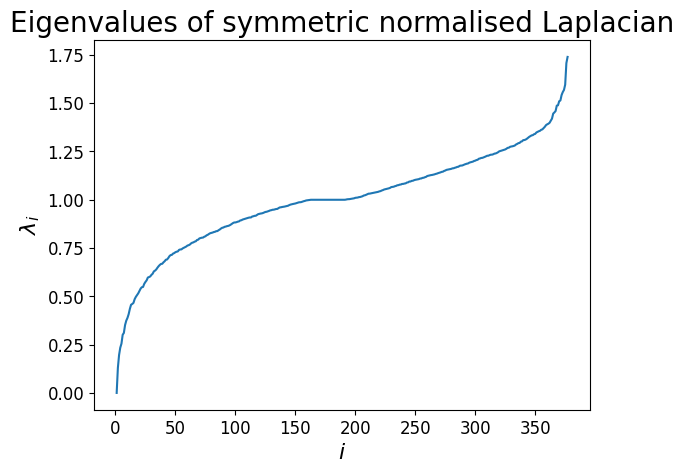

In [ ]:
# plot eigenvalues
fig, ax = plt.subplots(1)
ax.plot(np.arange(1, N+1), eigenvals)
ax.set(title="Eigenvalues of symmetric normalised Laplacian", xlabel=r"$i$", ylabel=r"$\lambda_i$")
plt.show()

We confirm that the first eigenvalue is $\lambda_1=0$, but we are more interested in the second eigenvalue $\lambda_2>0$, which is also called the algebraic connectivity.

In [ ]:
## EDIT THIS CELL

# print first and second eigenvalues
print("First eigenvalue:", round(eigenvals[0],2))    # <-- SOLUTION
print("Second eigenvalue:", round(eigenvals[1],2))   # <-- SOLUTION

First eigenvalue: -0.0
Second eigenvalue: 0.13


As $\lambda_2$, is small we expect that the graph has a good bipartition. We will study this later.

### Graph visualisation using Laplacian eigenmaps

But first we will use the second (Fiedler) eigenvector $\boldsymbol{v}_2$ and third eigengenvector $\boldsymbol{v}_3$ to visualise the network. Using these two Laplacian eigenvectors (also called Laplacian eigenmaps) as $\boldsymbol{x}$ and $\boldsymbol{y}$ coordinates of the nodes gives us a good two-dimensional representation of the graph (a spectral embedding). We can improve the visualisation when normalising the coordinates such that $\boldsymbol{x}=D^{-1/2}\boldsymbol{v}_2$ and $\boldsymbol{y}=D^{-1/2}\boldsymbol{v}_3$.

In [ ]:
## EDIT THIS CELL

# get second (Fiedler) and third eigenvectors
v2 = eigenvecs[1]        # <-- SOLUTION
v3 = eigenvecs[2]        # <-- SOLUTION

# normalise coordinates
x = D_sqrt_inv @ v2      # <-- SOLUTION
y = D_sqrt_inv @ v3      # <-- SOLUTION

We can simply plot the graph by drawing lines between the embeddings of two connected nodes. Additionally, we can scale the node size dependent on the degree. Below we provide a function that can be used for plotting the graph.

In [ ]:
def plot_graph(adjacency, x_coord, y_coord, node_size, node_color):
    """Plot undirected graph.

    Parameters:
        adjacency (np.array): N x N adjacency matrix.
        x_coord (np.array): X-coordinates for N nodes.
        y_coord (np.array): Y-coordinates for N nodes.
        node_size (np.array): Size for each of the N nodes.
        node_color (np.array): Color for each of the N nodes.
    """

    # plot
    fig, ax = plt.subplots(1)

    # plot edges
    for i in range(N):
        for j in range(i+1,N):
            if adjacency[i,j] > 0:
                ax.plot([x_coord[i],x_coord[j]],[y_coord[i],y_coord[j]], color="black", alpha=0.5, linewidth=0.3)

    # plot nodes
    scatter = ax.scatter(x_coord,y_coord,s=0.2*node_size, c=node_color, zorder=10)

    return ax

We can now plot the graph with nodes coloured according to type.

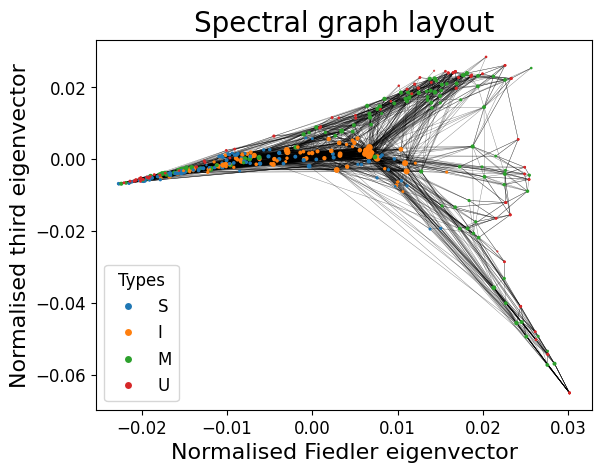

In [ ]:
# plot graph
ax = plot_graph(adjacency=A, x_coord=x, y_coord=y, node_size=d, node_color=color_type)

# set labels
ax.set(xlabel="Normalised Fiedler eigenvector", ylabel="Normalised third eigenvector", title="Spectral graph layout")

# create legend for node types
types_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=cmap(value)) for value, label in value_to_type.items()]
plt.legend(handles=types_legend, title='Types');


We observe that the muscles (U) are located in the periphery of the network, while the most connected inter neurons (I) are located in the center.

Another way to visualise the graph is to directly use the node degree $\boldsymbol{d}$ as the y-coordinate, i.e., $\boldsymbol{y}=\boldsymbol{d}$.

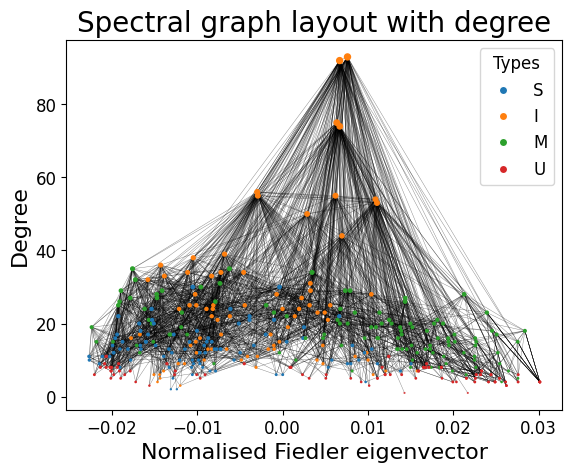

In [ ]:
# plot graph
ax = plot_graph(adjacency=A, x_coord=x, y_coord=d, node_size=d, node_color=color_type)

# set labels
ax.set(xlabel="Normalised Fiedler eigenvector", ylabel="Degree", title="Spectral graph layout with degree")

# create legend for node types
types_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=cmap(value)) for value, label in value_to_type.items()]
plt.legend(handles=types_legend, title='Types');


This visualisation gives a more decluttered picture and is very useful to distinguish the different node types in the network. For the rest of the notebook, we will thus use this visualisation.

As you have learnt by now, graph visualisation is a very interesting topic in itself and there are many algorithms to plot various graphs, including very large ones.

### Questions:

- Why is graph visualisation not unique?
- Can you come up with alternative graph visualisations?

### Bipartitioning using Fiedler eigenvector

We will now use the second (Fiedler) eigenvector $\boldsymbol{v}_2$ to bipartition the network into two communities, given by the sign of $\boldsymbol{v}_2$.

In [ ]:
## EDIT THIS CELL

# bipartition is given by sign of Fiedler eigenvector
bipartition = np.asarray(v2>0, dtype=int)       # <-- SOLUTION

As the algebraic connectivity $\lambda_2$ is small, we expect that the bipartition is very balanced. To confirm this we compute the number of nodes and the total degree of both communities.

In [ ]:
## EDIT THIS CELL

# compute statistics for bipartition
print("Size of first community:", np.sum(bipartition==0))               # <-- SOLUTION
print("Total degree of first community:", np.sum(d[bipartition==0]))    # <-- SOLUTION

print("\nSize of second community:", np.sum(bipartition==1))            # <-- SOLUTION
print("Total degree of second community:", np.sum(d[bipartition==1]))   # <-- SOLUTION

Size of first community: 181
Total degree of first community: 2913

Size of second community: 196
Total degree of second community: 2787


Indeed, we find that the communities of the bipartition contain a very similar number of nodes and also have a similar total degree. It is illustrative to visualise the bipartition in the network.

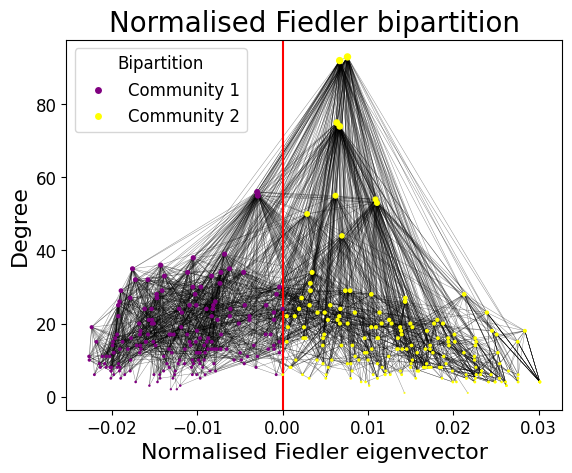

In [ ]:
# use different colours for bipartition
cmap_binary = {0 : "purple", 1 : "yellow"}
color_bipartition = [cmap_binary[i] for i in bipartition]

# plot graph
ax = plot_graph(adjacency=A, x_coord=x, y_coord=d, node_size=d, node_color=color_bipartition)

# plot cut induced by Fiedler eigenvector
ax.axvline(x=0, color="red")

# create legend for bipartition
bipartition_legend = [plt.Line2D([0], [0], marker='o', color='w', label="Community 1", markerfacecolor="purple"),
                plt.Line2D([0], [0], marker='o', color='w', label="Community 2", markerfacecolor="yellow")]
plt.legend(handles=bipartition_legend, title='Bipartition')

# plot labels
ax.set(xlabel="Normalised Fiedler eigenvector", ylabel="Degree", title="Normalised Fiedler bipartition");


While the nodes with the highest degree belong to community 2, the degree distribution seems to be quite uniform between the two communities. We confirm this by plotting the degree distributions as histograms.

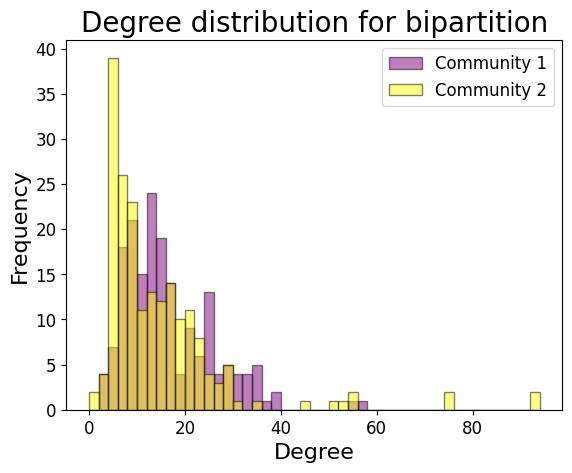

In [ ]:
# visualise degree distributions for both communities
fig, ax = plt.subplots(1)
bins = np.arange(0,d.max()+2,2)
ax.hist(d[bipartition==0], bins=bins, alpha=0.5, edgecolor='black', label=r"Community 1", color="purple")
ax.hist(d[bipartition==1], bins=bins, alpha=0.5, edgecolor='black', label=r"Community 2", color="yellow")
ax.set(xlabel="Degree", ylabel="Frequency", title="Degree distribution for bipartition")
ax.legend()
plt.show()

## Spectral clustering using more Laplacian eigenvectors

To go beyond bipartitions, we can use more Laplacian eigenvectors and apply what is called *spectral clustering*, where we apply $k$-means clustering to the Laplacian eigenmaps.

### Code for $K$-means clustering from Week 7

To use $K$-means clustering we first copy-paste the code from Week 7.

In [ ]:
# EDIT THIS FUNCTION
def compute_within_distance(centroids, X, labels):
    """
    Compute the within-cluster distance.

    Parameters:
        centroids (np.ndarray): Centroids matrix, shape (k, p).
        X (np.ndarray): Samples matrix, shape (N, p).
        labels (np.ndarray): Cluster index of each sample, shape (N,).

    Retruns:
        within_distance (float): Within-cluster distance.
    """

    within_distance = 0.0
    K, p = centroids.shape

    # calculate the contribution to W(C) for each cluster
    for l in range(len(centroids)):
        centroid = centroids[l]
        # skip empty clusters
        if np.isinf(centroid).any():
            continue

        # Select samples belonging to label=l.
        X_cluster = X[labels == l]

        # We need to add the `X_cluster` contribution to `within_distance`
        # Compute the W(C) contribution for each sample
        cluster_se = (X_cluster - centroid)**2 # <-- SOLUTION
        assert cluster_se.shape == (len(X_cluster), p) # <-- SOLUTION
        # Calculate the total contribution for the lth cluster
        # and add to  the running total
        within_distance += np.sum(cluster_se) # <-- SOLUTION

    return within_distance

# EDIT THIS FUNCTION
def compute_centroids(K, X, labels):
    """
    Compute the centroids of the clustered points X.

    Parameters:
        K (int): The number of clusters.
        X (np.ndarray): Samples matrix, shape (N, p).
        labels (np.ndarray): Cluster index of each sample, shape (N,).

    Returns:
        centroids (np.ndarray): Centroids matrix, shape (k, p).
    """
    N, p = X.shape

    centroids = np.zeros((K, p))

    # EDIT THE NEXT LINES
    for label in range(K):
        cluster_X_l = X[labels == label] # <-- SOLUTION
        # if cluster is empty, set all features values to Inf
        if cluster_X_l.shape[0] == 0:
          centroids[label] = np.Inf # <-- SOLUTION
        else:
          centroids[label] = cluster_X_l.mean(axis=0) # <-- SOLUTION


    return centroids
# EDIT THIS FUNCTION
def kmeans_assignments(centroids, X):
    """
    Assign every sample  the index of the closest centroid.

    Parameters:
        centroids (np.ndarray): Centroids matrix, shape (k, p).
        X (np.ndarray): Samples matrix, shape (N, p).

    Returns:
        labels (np.ndarray): Cluster index of each sample, shape (N,).
    """
    K, p = centroids.shape
    N, _ = X.shape

    # Compute distances between data points and centroids. Assumed shape: (k, N).
    distances = np.vstack([np.linalg.norm(X - c, axis=1) for c in centroids]) # <-- SOLUTION
    assert distances.shape == (K, N), f"Unexpected shape {distances.shape} != {(K, N)}"

    labels = np.argmin(distances, axis=0) # <-- SOLUTION

    return labels

# EDIT THIS FUNCTION
def kmeans_clustering(X, K, rng,
                      max_iters=1000,
                      epsilon=0.0,
                      callback=None,
                      print_empty=False):
    """
    Apply k-means clustering algorithm on the samples in `X` to discover
    k clusters.

    Parameters:
        X (np.ndarray): Samples matrix, shape (N, p).
        K (int): The number of clusters.
        rng (np.random.default_rng): A random number generator.
        max_iters (int): Maximum number of iterations.
        epsilon (float): The convergence threshold.
        callback (Callable): Function to be called on the labels and centroids.
        print_empty (bool): Whether to print the number of empty clusters.

    Returns:
        labels (np.ndarray): Cluster index of each sample, shape (N,).
        centroids (np.ndarray): Centroids matrix, shape (k, p).
        within_distance (float): Within-cluster distance.
    """
    # Step 0: randomly initialise the cluster assignments.
    labels = rng.choice(K, size=len(X), replace=True) # <-- SOLUTION
    # initialise within_distance
    within_distance = np.inf

    for _ in range(max_iters):
        # Step 1: compute the centroids
        centroids = compute_centroids(K, X, labels) # <-- SOLUTION

        if callback != None:
            callback(labels, centroids)

        # Step 2: reassignments.
        new_labels = kmeans_assignments(centroids, X) # <-- SOLUTION

        # Step 3: termination check
        _within_distance = compute_within_distance(centroids, X, labels)
        if all(labels == new_labels) or abs(_within_distance - within_distance) < epsilon: # <-- SOLUTION
            break

        labels = new_labels
        within_distance = _within_distance


    num_empty = K - len(np.unique(labels))
    if (num_empty != 0) & print_empty :
      print(num_empty, 'empty cluster(s) present.')

    return labels, centroids, within_distance

# EDIT THIS FUNCTION
def kmeans_clustering_multi_runs(X, K, max_iters=100,
                                 epsilon=0.0,
                                 n_runs=100, seed=0):
    """
    Perform multiple runs (with different initialisations) of kmeans algorithm
    and return the best clustering using the within-cluster distance.

    Parameters:
        X (np.ndarray): Samples matrix, shape (N, p).
        K (int): The number of clusters.
        max_iters (int): Maximum number of iterations.
        epsilon (float): The convergence threshold.
        n_runs (int): The number of runs of kmeans with different initialisations.
        seed (int): A seed value before starting the n_runs loop.

    Returns:
        labels (np.ndarray): Cluster index of each sample, shape (N,).
        centroids (np.ndarray): Centroids matrix, shape (k, p).
        intermediates (list): The clustering trajectory for the best clustering.
        within_distance (float): Within-cluster distance.
    """
    # We fix the seed once before starting the n_runs.
    rng = np.random.default_rng(seed=seed)
    min_within_distance = np.inf
    best_clustering = (None, None, None)

    for _ in range(n_runs):

        # define callback function
        intermediates = []
        callback = lambda labels, centroids: intermediates.append((labels, centroids))

        labels, centroids, within_distance = kmeans_clustering(X, K, rng,
                                                    max_iters=max_iters,
                                                    epsilon=epsilon,
                                                    callback=callback) # <-- SOLUTION

        if within_distance < min_within_distance:
            # store results so they are not overwritten
            best_clustering = labels, centroids, intermediates
            min_within_distance = within_distance

    labels, centroids, intermediates = best_clustering
    return labels, centroids, intermediates, min_within_distance

### Using $K$-means for spectral clustering

Let us define a $N\times r$ feature matrix $X$ that contains the first $r>0$ Laplacian eigenvectors (corresponding to non-zero eigenvalues) as columns. For spectral clustering, it is recommended to first obtain a normalised feature matrix $Y$ from $X$ following the famous paper by [Ng, Jordan, and Weiss 2001](https://papers.nips.cc/paper/2001/file/801272ee79cfde7fa5960571fee36b9b-Paper.pdf):

$$Y_{ij}=\frac{X_{ij}}{\sqrt{\sum_{j=1}^r X_{ij}^2}},$$

such that the rows of $Y$ have unit lengths. We compute $Y$ for $r=10$.

In [ ]:
## EDIT THIS CELL

# stack first r eigenvectors in columns to get spectral embeddings
r = 10
X = eigenvecs[1:r+1].T      # <-- SOLUTION

# normalise to unit length
Y = np.diag(1/np.sqrt(np.sum(np.square(X), axis=1))) @ X    # <-- SOLUTION

Treating each row of $Y$ as a point in $\mathbb{R}^r$ gives us $r$-dimensional embeddings for the nodes in the network. We can then cluster the network using $k$-means. Our question is whether we can retrieve the four node types using spectral clustering, so we set $K=4$.

In [ ]:
## EDIT THIS CELL

# apply K-means clustering to spectral embeddings
spectral_partition, _, _, _ = kmeans_clustering_multi_runs(Y, 4) # <-- SOLUTION

Already through visualising the partition, it seems like there is a low correspondence to the node types when compared to the visualsiations above.

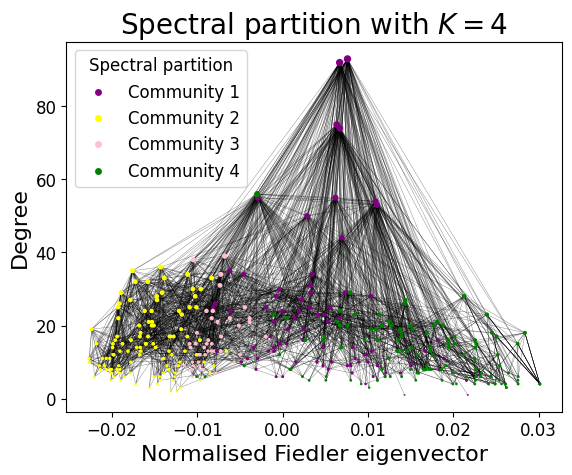

In [ ]:
# use different colours for spectral partition
cmap_partition = {0 : "purple", 1 : "yellow", 2 : "pink", 3 : "green"}
color_partition = [cmap_partition[i] for i in spectral_partition]

# plot graph
ax = plot_graph(adjacency=A, x_coord=x, y_coord=d, node_size=d, node_color=color_partition)

# create legend for spectral partition
partition_legend = [plt.Line2D([0], [0], marker='o', color='w', label="Community 1", markerfacecolor="purple"),
                      plt.Line2D([0], [0], marker='o', color='w', label="Community 2", markerfacecolor="yellow"),
                      plt.Line2D([0], [0], marker='o', color='w', label="Community 3", markerfacecolor="pink"),
                      plt.Line2D([0], [0], marker='o', color='w', label="Community 4", markerfacecolor="green")]
plt.legend(handles=partition_legend, title='Spectral partition')

# plot labels
ax.set(xlabel="Normalised Fiedler eigenvector", ylabel="Degree", title=r"Spectral partition with $K=4$")
plt.show()

We also observe that the degree distributions of the different clusters in the spectral partition are very similar, so unlike the degree distributions according to the different node types discussed above.

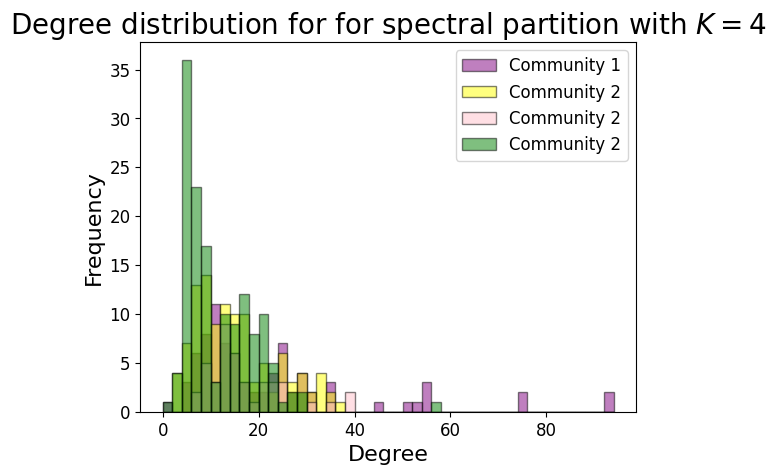

In [ ]:
# visualise degree distributions for the four spectral communities
fig, ax = plt.subplots(1)
bins = np.arange(0,d.max()+2,2)
ax.hist(d[spectral_partition==0], bins=bins,alpha=0.5, edgecolor='black', label=r"Community 1", color="purple")
ax.hist(d[spectral_partition==1], bins=bins,alpha=0.5, edgecolor='black', label=r"Community 2", color="yellow")
ax.hist(d[spectral_partition==2], bins=bins,alpha=0.5, edgecolor='black', label=r"Community 2", color="pink")
ax.hist(d[spectral_partition==3], bins=bins,alpha=0.5, edgecolor='black', label=r"Community 2", color="green")
ax.set(xlabel="Degree",ylabel="Frequency",title="Degree distribution for for spectral partition with $K=4$")
ax.legend()
plt.show()

However, it is expected that the spectral partition is not consistent with the partition of node types because it actually reflects the physical positions of the neurons in the organism (we can't show this here). This is the case because the spectral partition is obtained from the Laplacian that encodes the connectivity of neurons in a physical organism.

### Using Normalised Variation of Information for comparing partitions

We implement the Normalised Variation of Information (NVI) to compare the spectral partition with the node types (which constitutes an alternative partition of the network). For two partitions $X$ and $Y$ you can compute the entropies $\mathrm H(X)$ and $\mathrm H(Y)$ and the mutual information $\mathrm{MI}(X,Y)$. The $\mathrm{NVI}$ is then given by:

$$\mathrm{NVI}(X,Y)=\frac{ \mathrm H(X)+\mathrm H(Y)-2 \mathrm{MI}(X,Y)}{\mathrm H(X)+\mathrm H(Y)- \mathrm{MI}(X,Y)}$$

The NVI is a metric on the space of partitions and ranges between 0 (partitions are the same) to 1.

In [ ]:
## EDIT THIS CELL

def compute_NVI(partition_1,partition_2):
    """Computes NVI of two partitions.

    Parameters:
        partition_1 (np.array): Encoding for partition 1.
        partition_2 (np.array): Encoding for partition 2.

    Returns:
        NVI (float): NVI of the two partitions.
    """
    # check if partitions are defined on the same underlying space
    assert len(partition_1) == len(partition_2), "Partition arrays must have same length"

    # get number of points
    N = len(partition_1)

    # get communities as sets from partition 1
    communities_1 = []
    for index in np.unique(partition_1):
        community = set(np.where(partition_1==index)[0])
        communities_1.append(community)

    # get communities as sets from partition 2
    communities_2 = []
    for index in np.unique(partition_2):
        community = set(np.where(partition_2==index)[0])
        communities_2.append(community)

    # compute number of communities
    n1 = len(communities_1)
    n2 = len(communities_2)

    # compute probabilities for the two partitions
    p1 = np.asarray([len(community) for community in communities_1]) / N        # <-- SOLUTION
    p2 = np.asarray([len(community) for community in communities_2]) / N        # <-- SOLUTION

    # compute joint probabilities
    p12 = np.zeros((n1,n2))
    for i in range(n1):
        for j in range(n2):
            p12[i,j] = len(communities_1[i].intersection(communities_2[j]))/N   # <-- SOLUTION

    # compute entropy
    H1 = - np.sum(p1 * np.log(p1))  # <-- SOLUTION
    H2 = - np.sum(p2 * np.log(p2))  # <-- SOLUTION

    # compute mutual information
    MI = 0
    for i in range(n1):
        for j in range(n2):
            if p12[i,j] > 0:
                MI += p12[i,j] * np.log(p12[i,j]/(p1[i]*p2[j])) # <-- SOLUTION

    # compute NVI
    NVI = (H1 + H2 - 2 * MI) / (H1 + H2 - MI)   # <-- SOLUTION

    return NVI


You can check your implementation with the following cell.

In [ ]:
# check for two test cases
partition_1 = np.asarray([0,0,0,1,1,1])
partition_2 = np.asarray([0,1,0,1,0,1])
npt.assert_allclose(compute_NVI(partition_1,partition_2), 0.9574079427713601)

partition_3 = np.asarray([3,2,0,1,1,1])
partition_4 = np.asarray([0,0,0,0,0,1])
npt.assert_allclose(compute_NVI(partition_3,partition_4), 0.9152282678756786)

We can now compute the NVI between the spectral partition and the node type.

In [ ]:
## EDIT THIS CELL
print("NVI of spectral partition and node types:",
      round(compute_NVI(node_type,spectral_partition),3)) # <-- SOLUTION

NVI of spectral partition and node types: 0.837


The NVI confirms our observations that the spectral partition is actually not very similar to the partition of node types.

We conclude here by double-checking some of the metric properties of the NVI.

In [ ]:
# we can check that the NVI is symmetric
npt.assert_allclose(compute_NVI(spectral_partition,node_type), compute_NVI(node_type,spectral_partition))

# and that the distance of a partition to itself is zero
npt.assert_allclose(compute_NVI(spectral_partition,spectral_partition), 0, atol=1e-15)
npt.assert_allclose(compute_NVI(node_type,node_type), 0, atol=1e-15)

## Analysing the directed C. Elegans network

As the node types I, S, M and U actually correspond to different functionalities of neurons in the organism, we expect that they play different "roles" in the network. We saw this already when looking at the degree distribution of the different types, where the inter neurons (I) had the the highest degrees.

We can improve our analysis by looking not only at the degree in the undirected network, but studing the in- and out-degrees in the directed C. Elegans network.

Let us start with compiling the directed unweighted C. Elegans network whose adjacency matrix we denote by $B$ such that $B_{ij}=1$ if $A_{\text{raw}, ij}>0$ and $B_{ij}=0$ otherwise.

In [ ]:
## EDIT THIS CELL

# obtain directed adjacency matrix
B = np.zeros_like(A_raw)    # <-- SOLUTION
B[(A_raw) > 0] = 1          # <-- SOLUTION

We can then compute the in-degree $d_{\mathrm{in}}$ and out-degree $d_{\mathrm{out}}$ of the directed graph corresponding to $B$.

In [ ]:
## EDIT THIS CELL

# compute in-degree
d_in = B @ np.ones(N)   # <-- SOLUTION

# compute out-degree
d_out = B.T @ np.ones(N)  # <-- SOLUTION

We now plot the neurons in a scatter plot with x-coordinate given by the in-degree and y-coordinate given by the out-degree.

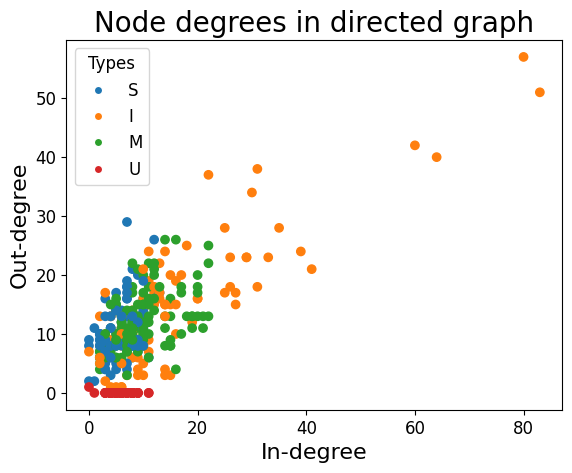

In [ ]:
# scatter plot in- and out-degrees
fig, ax = plt.subplots(1)

# plot nodes
scatter = ax.scatter(d_in, d_out, c=color_type, zorder=10)

# plot legend
plt.legend(handles=types_legend, title='Types')

# plot labels
ax.set(xlabel="In-degree", ylabel="Out-degree", title="Node degrees in directed graph")
plt.show()

We can see that the combination of in- and out-degreens helps us to distinguish the different types. Most strikingly, the muscles have a very low out-degree (mostly 0) and only incoming nodes as they sit at the bottom of the hierarchy in the nervous system of C. Elegans.

Next we will apply k-means clustering to a feature matix $Z$ whose columns correspond to the in- and out-degrees and we apply a log-transformation as the degree distribution is skewed. In particular, the first column is given by $\log(1+d_\mathrm{in})$ and second column by $\log(1+d_\mathrm{out})$.

In [ ]:
## EDIT THIS CELL

# combine log-transformed in- and out-degree to new feature matrix
Z = np.asarray([np.log(1+d_in),np.log(1+d_out)]).T      # <-- SOLUTION

# apply k-means clustering to in and out-degrees
in_out_partition, _, _, _ = kmeans_clustering_multi_runs(Z, 4)  # <-- SOLUTION

We can visualise the obtained clustering in a scatter plot.

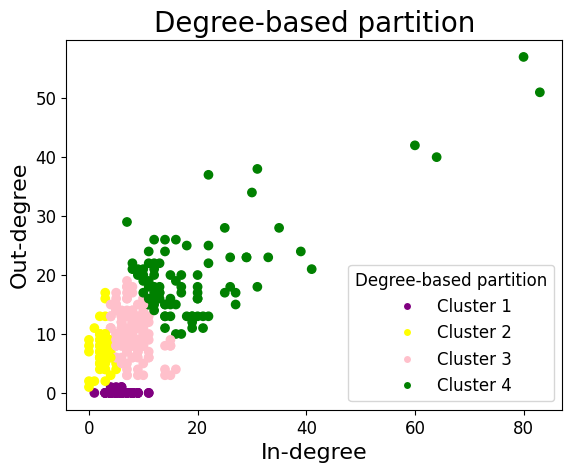

In [ ]:
# use different colours for spectral partition
cmap_partition = {0 : "purple", 1 : "yellow", 2 : "pink", 3 : "green"}
color_partition = [cmap_partition[i] for i in in_out_partition]

# scatter plot in- and out-degrees
fig, ax = plt.subplots(1)

# plot nodes
scatter = ax.scatter(d_in, d_out, c=color_partition, zorder=10)

# create legend for clustering
partition_legend = [plt.Line2D([0], [0], marker='o', color='w', label="Cluster 1", markerfacecolor="purple"),
                      plt.Line2D([0], [0], marker='o', color='w', label="Cluster 2", markerfacecolor="yellow"),
                      plt.Line2D([0], [0], marker='o', color='w', label="Cluster 3", markerfacecolor="pink"),
                      plt.Line2D([0], [0], marker='o', color='w', label="Cluster 4", markerfacecolor="green")]
plt.legend(handles=partition_legend, title='Degree-based partition')

# plot labels
ax.set(xlabel="In-degree", ylabel="Out-degree", title="Degree-based partition")
plt.show()

Comparing our results to the previous plot we observe that the clusters partially match the different node types. For example, Cluster 1 captures the muscles (U) and Cluster 4 captures many of the high in-degree inter neurons (I). However, the partition does not fully distinguish the different node types.

To quantify the correspondence to the ground truth node types, we evaluate the NVI of the degree-based partition and the node types.

In [ ]:
## EDIT THIS CELL
print("NVI of in-degree out-degree partition and node types:",
      round(compute_NVI(node_type,in_out_partition),3))     # <-- SOLUTION

NVI of in-degree out-degree partition and node types: 0.712


We observe a slightly lower NVI value as compared to spectral clustering of the undirected graph. This suggests that the directed graph contains important information about the functionality of the different nodes.

The reason for this is that the analysis of in-degree and out-degree patterns of nodes can recover the different roles that nodes play in the network. If you want to read more on how to distinguish nodes in a directed graph based on in-coming and out-going paths you can have a look at a paper by Kathryn Cooper and Mauricio Barahona on *Role-based similarity in directed networks*: https://arxiv.org/abs/1012.2726